In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from glob import glob
import numpy as np
import os
from sys import exit as ext
import copy
from bisect import bisect_left
#from oco_post_class_ywc import *
from matplotlib import cm
from scipy.interpolate import interpn
from scipy import stats
import geopy.distance
import xarray as xr
import seaborn as sns


plt.rcParams.update({'axes.facecolor':'white'})
%matplotlib inline

"""

from matplotlib import font_manager

font_path = '/System/Library/Fonts/ArialHB.ttc'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#"""

import warnings
warnings.filterwarnings("ignore")

In [2]:
png       = ['../dat/20150622.png',[-64.5552,-50.1085,-14.2336,2.2510]]
img = png[0]
wesn= png[1]

In [3]:
def grab_cfg(path):
    """
    Read the setting information in the assigned csv file.
    path: relative or absolute path to the setting csv file.
    """
    cfg_file = pd.read_csv(path, header=None, index_col=0)
    result = {'cfg_name':path.split('/')[-1].replace('.csv', '')}
    for ind in cfg_file.index.dropna():
        contents = [str(i) for i in cfg_file.loc[ind].dropna() if str(i)[0] != '#']
        if len(contents) == 1:
            result[ind] = contents[0]
        elif len(contents) > 1:
            result[ind] = contents
    return result

def output_h5_info(cfg, index):
    """
    Check whether the output h5 name is saved in cfg file
    """
    try: 
        cfg_file = grab_cfg(cfg)
    except OSError as err:
        print('{} not exists!'.format(cfg))
        return False
    if index in cfg_file.keys():
        if cfg_file[index][-2:] == 'h5':
            return cfg_file[index]
    else:
        return False
    
def get_slope_1km(OCO_class,fp,z,mode='unperturb'):
    nwl=OCO_class.sls_1km[z,fp,:].shape[0]
    flt=np.where(OCO_class.sls_1km[z,fp,:]>1e-6)
    #flt=np.where(~np.isnan(sls[:]))
    use=len(flt[0])
    if use==nwl:
        w=1./OCO_class.sls_1km[z,fp,:]    
        if mode=='unperturb':
            x=OCO_class.rad_1km_c3d[z,fp,:]/OCO_class.toa[:]*np.pi
        else:
            x=OCO_class.rad_1km_clr[z,fp,:]/OCO_class.toa[:]*np.pi
        res=np.polyfit(x,OCO_class.sl_1km[z,fp,:],1,w=w,cov=True) # now get covariance as well!
        slope,intercept=res[0]
        slopestd=np.sqrt(res[1][0][0])
        interceptstd=np.sqrt(res[1][1][1])
    else:
        slope=np.nan; slopestd=np.nan; intercept=np.nan; interceptstd=np.nan
    return(slope,slopestd,intercept,interceptstd)

def get_slope_25p(OCO_class,fp,z,mode='unperturb'):
    nwl=OCO_class.sls_25p[z,fp,:].shape[0]
    flt=np.where(OCO_class.sls_25p[z,fp,:]>1e-6)
    #flt=np.where(~np.isnan(sls[:]))
    use=len(flt[0])
    if use==nwl:
        w=1./OCO_class.sls_25p[z,fp,:]
        if mode=='unperturb':
            x=OCO_class.rad_25p_c3d[z,fp,:]/OCO_class.toa[:]*np.pi
        else:
            x=OCO_class.rad_25p_clr[z,fp,:]/OCO_class.toa[:]*np.pi   
        res=np.polyfit(x,OCO_class.sl_25p[z,fp,:],1,w=w,cov=True) # now get covariance as well!
        slope,intercept=res[0]
        slopestd=np.sqrt(res[1][0][0])
        interceptstd=np.sqrt(res[1][1][1])
    else:
        slope=np.nan; slopestd=np.nan; intercept=np.nan; interceptstd=np.nan
    return(slope,slopestd,intercept,interceptstd)

def slopes_propagation(OCO_class,mode='unperturb'): # goes through entire line for a given footprint fp
    OCO_class.slope_1km=np.zeros([OCO_class.nz,OCO_class.nf,2])
    OCO_class.inter_1km=np.zeros([OCO_class.nz,OCO_class.nf,2])
    OCO_class.slope_25p=np.zeros([OCO_class.nz,OCO_class.nf,2])
    OCO_class.inter_25p=np.zeros([OCO_class.nz,OCO_class.nf,2])
    for z in range(OCO_class.nz):
        for fp in range(OCO_class.nf):
            if ~ np.isnan(OCO_class.co2[z,fp,]):
                slope,slopestd,inter,interstd=OCO_class.get_slope(fp,z,mode='unperturb')
                OCO_class.slope[z,fp,:]=[slope,slopestd]
                OCO_class.inter[z,fp,:]=[inter,interstd]
                slope,slopestd,inter,interstd=get_slope_1km(OCO_class, fp,z,mode='unperturb')
                OCO_class.slope_1km[z,fp,:]=[slope,slopestd]
                OCO_class.inter_1km[z,fp,:]=[inter,interstd]  
                slope,slopestd,inter,interstd=get_slope_25p(OCO_class, fp,z,mode='unperturb')
                OCO_class.slope_25p[z,fp,:]=[slope,slopestd]
                OCO_class.inter_25p[z,fp,:]=[inter,interstd]  

In [4]:
def near_rad_calc(OCO_class):
    rad_mca_ipa0 = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_ipa  = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_3d   = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)

    rad_mca_ipa0_std = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_ipa_std  = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_3d_std   = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)

    rad_mca_ipa0[...] = np.nan
    rad_mca_ipa[...] = np.nan
    rad_mca_3d[...] = np.nan

    rad_mca_ipa0_std[...] = np.nan
    rad_mca_ipa_std[...] = np.nan
    rad_mca_3d_std[...] = np.nan

    rad_mca_ipa0_25 = rad_mca_ipa0.copy()
    rad_mca_ipa_25 = rad_mca_ipa0.copy()
    rad_mca_3d_25 = rad_mca_ipa0.copy()

    rad_mca_ipa0_std_25 = rad_mca_ipa0.copy()
    rad_mca_ipa_std_25 = rad_mca_ipa0.copy()
    rad_mca_3d_std_25 = rad_mca_ipa0.copy()
    count = 0
    for i in range(OCO_class.lat.shape[0]):
        for j in range(OCO_class.lat.shape[1]):
            if ~ np.isnan(OCO_class.co2[i, j]):
                lon0 = OCO_class.lon[i, j]
                lat0 = OCO_class.lat[i, j]      
                index_lon = np.argmin(np.abs(OCO_class.lon2d[:, 0]-lon0))
                index_lat = np.argmin(np.abs(OCO_class.lat2d[0, :]-lat0))

                center = (lon0, lat0)
                tmp_clr, tmp_c1d, tmp_c3d = [], [], []
                tmp_clrs, tmp_c1ds, tmp_c3ds = [], [], []
                test_range = (np.arange(-10, 10+1))
                for x in test_range:
                    for y in test_range:
                        try:
                            interest_loc = (OCO_class.lon2d[index_lon+x, 0], OCO_class.lat2d[0, index_lat+y])
                            if geopy.distance.distance(center, interest_loc).km <= 1.0:

                                tmp_clr.append(OCO_class.rad_clr[index_lon+x, index_lat+y])
                                tmp_c1d.append(OCO_class.rad_c1d[index_lon+x, index_lat+y])
                                tmp_c3d.append(OCO_class.rad_c3d[index_lon+x, index_lat+y])
                                tmp_clrs.append(OCO_class.rad_clrs[index_lon+x, index_lat+y])
                                tmp_c1ds.append(OCO_class.rad_c1ds[index_lon+x, index_lat+y])
                                tmp_c3ds.append(OCO_class.rad_c3ds[index_lon+x, index_lat+y])
                                count += 1
                        except:
                            None
                
                rad_mca_ipa0[i, j, :] = np.nanmean(np.array(tmp_clr), axis=0)
                rad_mca_ipa[i, j, :]  = np.nanmean(np.array(tmp_c1d), axis=0)
                rad_mca_3d[i, j, :]   = np.nanmean(np.array(tmp_c3d), axis=0)

                rad_mca_ipa0_std[i, j, :] = (np.nanstd(np.array(tmp_clr), axis=0))
                rad_mca_ipa_std[i, j, :]  = (np.nanstd(np.array(tmp_c1d), axis=0))
                rad_mca_3d_std[i, j, :]   = (np.nanstd(np.array(tmp_c3d), axis=0))


                rad_mca_ipa0_25[i, j, :] = np.nanmean(OCO_class.rad_clr[index_lon-2:index_lon+3, 
                                                                 index_lat-2:index_lat+3], 
                                                      axis=(0, 1))
                rad_mca_ipa_25[i, j, :]  = np.nanmean(OCO_class.rad_c1d[index_lon-2:index_lon+3, 
                                                                 index_lat-2:index_lat+3], 
                                                      axis=(0, 1))
                rad_mca_3d_25[i, j, :]   = np.nanmean(OCO_class.rad_c3d[index_lon-2:index_lon+3, 
                                                                 index_lat-2:index_lat+3], 
                                                      axis=(0, 1))
                
                rad_mca_ipa0_std_25[i, j, :] = (np.nanstd(OCO_class.rad_clr[index_lon-2:index_lon+3,
                                                                      index_lat-2:index_lat+3],
                                                          axis=(0, 1)))
                rad_mca_ipa_std_25[i, j, :]  = (np.nanstd(OCO_class.rad_c1d[index_lon-2:index_lon+3,
                                                                      index_lat-2:index_lat+3],
                                                          axis=(0, 1)))
                rad_mca_3d_std_25[i, j, :]   = (np.nanstd(OCO_class.rad_c3d[index_lon-2:index_lon+3,
                                                                      index_lat-2:index_lat+3],
                                                          axis=(0, 1)))
    print(count)
    OCO_class.rad_1km_clr = rad_mca_ipa0
    OCO_class.rad_1km_c1d = rad_mca_ipa
    OCO_class.rad_1km_c3d = rad_mca_3d

    OCO_class.rad_1km_clrs = rad_mca_ipa0_std
    OCO_class.rad_1km_c1ds = rad_mca_ipa_std
    OCO_class.rad_1km_c3ds = rad_mca_3d_std

    OCO_class.rad_25p_clr = rad_mca_ipa0_25
    OCO_class.rad_25p_c1d = rad_mca_ipa_25
    OCO_class.rad_25p_c3d = rad_mca_3d_25

    OCO_class.rad_25p_clrs = rad_mca_ipa0_std_25
    OCO_class.rad_25p_c1ds = rad_mca_ipa_std_25
    OCO_class.rad_25p_c3ds = rad_mca_3d_std_25
    
    OCO_class.sl_1km  = (OCO_class.rad_1km_c3d-OCO_class.rad_1km_clr) / OCO_class.rad_1km_clr        # S_lamda
    OCO_class.sls_1km = (OCO_class.rad_1km_c3ds/OCO_class.rad_1km_clr + OCO_class.rad_1km_clrs/OCO_class.rad_1km_clr)
    OCO_class.sl_25p  = (OCO_class.rad_25p_c3d-OCO_class.rad_25p_clr) / OCO_class.rad_25p_clr        # S_lamda
    OCO_class.sls_25p = (OCO_class.rad_25p_c3ds/OCO_class.rad_25p_clr + OCO_class.rad_25p_clrs/OCO_class.rad_25p_clr)

In [5]:
h1_unmodified = h5py.File('full-unmodified_20150622_30km_o2a_wco2.h5', "r")
h1_unpert = h5py.File('full-unperturb_20150622_30km_o2a_wco2.h5', "r")

h1_unpert.keys()

<KeysViewHDF5 ['aod', 'cpu_minutes', 'lat', 'lon', 'pert_o2', 'pert_sco2', 'pert_wco2', 'psur_MT_file', 'psur_retrieved', 'rfl1', 'rfl2', 'rfl3', 'snd', 'xco2_L2_file', 'xco2_retrieved', 'xco2_weighted_column']>

In [6]:
h1_unmodified.keys()

<KeysViewHDF5 ['aod', 'cpu_minutes', 'lat', 'lon', 'pert_o2', 'pert_sco2', 'pert_wco2', 'psur_MT_file', 'psur_retrieved', 'rfl1', 'rfl2', 'rfl3', 'snd', 'xco2_L2_file', 'xco2_retrieved', 'xco2_weighted_column']>

In [7]:
h1_unmodified['lon'][...]

array([-57.64875412, -57.62281418, -57.63144684, -57.62718582,
       -57.65705109, -57.60571671, -57.61422729, -57.64012909,
       -57.66566849, -57.73747253, -57.59719467, -57.83192825,
       -57.55891418, -57.72473907, -57.733181  , -57.73303986,
       -57.84463501, -57.65712357, -57.67812347, -57.84037781,
       -57.60617828, -57.67433167, -57.77203751, -57.55055237,
       -57.65286255, -57.61450577, -57.70788574, -57.5632019 ,
       -57.64448929, -57.82762527, -57.73732758, -57.66578674,
       -57.67005157, -57.78044891, -57.64419556, -57.80609894,
       -57.75098038, -57.72044754, -57.65279007, -57.652771  ,
       -57.72888947, -57.6231575 , -57.74226761, -57.84894562,
       -57.84887695, -57.7340126 , -57.79747009, -57.68658447,
       -57.79811478, -57.73840332, -57.74665451, -57.66138458,
       -57.69512177, -57.81916428, -57.43865967, -57.45561981,
       -57.45994186, -57.46854782, -57.44724655, -57.49873352,
       -57.45147705, -57.45989227, -57.47263336, -57.51

In [8]:
h1_unmodified['pert_o2'][...]

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0,

In [9]:
h1_unpert['pert_o2'][...][0][0]

0.389157606

In [10]:
h5_snd = h1_unmodified['snd'][...]
h5_lon = h1_unmodified['lon'][...]
h5_lat = h1_unmodified['lat'][...]

h5_unpert_snd = h1_unpert['snd'][...]

h5_xco2_retrieved_unmodified = h1_unmodified['xco2_retrieved'][...]
h5_xco2_retrieved_unpert = h1_unpert['xco2_retrieved'][...]
h5_xco2_L2_file = h1_unmodified['xco2_L2_file'][...]

h5_xco2_retrieved_unmodified[h5_xco2_retrieved_unmodified<100] = np.nan
h5_xco2_retrieved_unpert[h5_xco2_retrieved_unpert<100] = np.nan


In [11]:
(len(h5_xco2_retrieved_unmodified), len(h5_xco2_retrieved_unpert))

(228, 222)

In [12]:
litefile = '../dat/oco2_LtCO2_150622_B10206Ar_200730184707s.nc4'
lite = xr.open_dataset(litefile)

lon_w, lon_e = wesn[0], wesn[1]
lat_s, lat_n = np.min(h5_lat)-0.05, np.max(h5_lat)+0.05
lon_range = np.logical_and(lite.longitude >= lon_w, lite.longitude <= lon_e)
lat_range = np.logical_and(lite.latitude >= lat_s, lite.latitude <= lat_n)

select = np.where(np.logical_and(lon_range, lat_range))

lite_snd_list = np.array(lite.sounding_id[select], dtype=np.int)

In [13]:
lat_s, lat_n

(-2.376509714, 2.2966742989999998)

In [14]:
h5_snd[0]

2015062217261501

In [15]:

qf_snd = []
qf_array = np.zeros((h5_lat.shape[0], 3))
# qf, qf_bitflag, qf_simpleflag\
for i in range(h5_lat.shape[0]):
    snd = h5_snd[i]
    #print('-'*15)
    #print(snd)
    qf_snd.append(snd)
    if snd in lite_snd_list:
        index = np.where(lite_snd_list == snd)[0][0]
        xco2_quality_flag = np.float(lite.xco2_quality_flag[select][index])
        xco2_qf_bitflag = np.float(lite.xco2_qf_bitflag[select][index])
        xco2_qf_simple_bitflag = np.float(lite.xco2_qf_simple_bitflag[select][index])
        qf_array[i, :] = (xco2_quality_flag, xco2_qf_bitflag, xco2_qf_simple_bitflag)
    else:
        qf_array[i, :] = (np.nan,)*3


In [16]:
h5_snd==5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [19]:
snd_list = []
qf_list = []
o1_s, o2_s, o3_s = [], [], []
o1_i, o2_i, o3_i = [], [], []
lon_list, lat_list, = [], []
xco2_unmodified, xco2_unperturb, xco2_l2 = [], [], []
for snd in h5_snd:
    # unmodifed
    unmodified_index = np.where(h5_snd==snd)
    if ~np.isnan(qf_array[unmodified_index][0][0]):
        snd_list.append(str(int(snd)))
        qf_list.append(str(int(qf_array[unmodified_index][0][0])))
        xco2_unmodified.append(h5_xco2_retrieved_unmodified[unmodified_index][0])
        xco2_l2.append(h5_xco2_L2_file[unmodified_index][0])
        lon_list.append(h5_lon[unmodified_index][0])
        lat_list.append(h5_lat[unmodified_index][0])
        #print(qf_array[np.where(o1.snd==snd)][0][0])

        # unperturb
        #try:
        unperturb_index = np.where(h5_unpert_snd==snd)
        o1_i.append(h1_unpert['pert_o2'][...][unperturb_index][0][0])
        o2_i.append(h1_unpert['pert_wco2'][...][unperturb_index][0][0])
        o3_i.append(h1_unpert['pert_sco2'][...][unperturb_index][0][0])
        o1_s.append(h1_unpert['pert_o2'][...][unperturb_index][0][1])
        o2_s.append(h1_unpert['pert_wco2'][...][unperturb_index][0][1])
        o3_s.append(h1_unpert['pert_sco2'][...][unperturb_index][0][1])
        xco2_unperturb.append(h5_xco2_retrieved_unpert[unperturb_index][0])


        #o3_s.append(o3.slope_1km[np.where(o3.snd==snd)][0][0])


In [20]:
data = pd.DataFrame(np.array([np.array(snd_list), np.array(lon_list), np.array(lat_list), 
                              np.array(qf_list),
                              np.array(o1_i), np.array(o1_s), 
                              np.array(o2_i), np.array(o2_s), 
                              np.array(o3_i), np.array(o3_s),
                              np.array(xco2_unmodified), 
                              np.array(xco2_unperturb), 
                              np.array(xco2_l2)]).T,
                    columns=['SoundingID', 'longitude', 'latitude', 'quality_flag',
                             'o2a_intercept(a)', 'o2a_slope(b)', 
                             'wco2_intercept(a)', 'wco2_slope(b)',
                             'sco2_intercept(a)', 'sco2_slope(b)',
                             'xco2 (unmodified retrieval)', 'xco2 (uperturb retrieval)', 'xco2 (L2)'])

data.to_csv('retrieval_output.txt', sep='\t', encoding='ascii', index=False)

In [ ]:
r = range(385, 415, 1)
label_size = 14
plt.hist(h5_xco2_retrieved_unpert, bins=r, label='unperturbed', alpha=0.25)
plt.hist(h5_xco2_L2_file, bins=r, label='L2', alpha=0.25)

#plt.hist(h5_xco2_retrieved_o2a, bins=r, label='o2a slope', alpha=0.25)
#plt.hist(h5_xco2_retrieved_wco2, bins=r, label='wco2 slope', alpha=0.25)
#plt.hist(h5_xco2_retrieved_o2a_wco2, bins=r, label='o2a and wco2 slopes', alpha=0.25)

plt.legend()
plt.xlabel('CO2 (ppm)', fontsize=label_size)
plt.ylabel('Counts', fontsize=label_size)
#plt.xlim(385, 430)
plt.show()

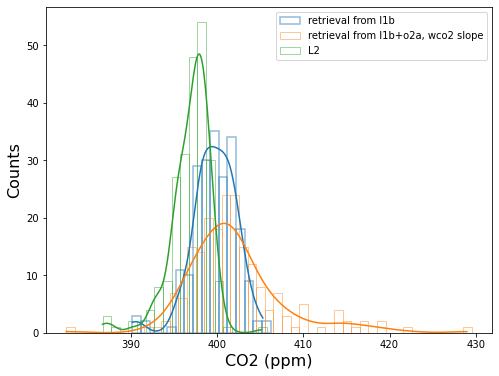

In [65]:
fig, (ax) = plt.subplots(1, 1, figsize=(8, 6), sharex=False, )
properties = {"kde":True, 
              "fill":False,
              #"bins":25,
              "binwidth":1,
              "alpha":0.5}
label_size = 16
sns.histplot(h5_xco2_retrieved_unmodified, ax=ax, label='retrieval from l1b', **properties)
sns.histplot(h5_xco2_retrieved_unpert, ax=ax, label='retrieval from l1b+o2a, wco2 slope', **properties)
sns.histplot(h5_xco2_L2_file, ax=ax, label='L2', **properties)

ax.set_xlabel('CO2 (ppm)', fontsize=label_size)
ax.set_ylabel('Counts', fontsize=label_size)

ax.legend()

#ax.set_xlim(385, 430)

plt.show()

In [ ]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6), sharex=False)
properties = {"kde":True, 
              "fill":False,
              #"bins":25,
              "binwidth":2,
              "alpha":0.5}
label_size = 16
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax, label='l1b', **properties)
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax2, label='l1b', **properties)
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax3, label='l1b', **properties)
sns.histplot(del_XCO2_o2a, ax=ax, label='l1b+o2a slope', **properties)
sns.histplot(del_XCO2_wco2, ax=ax2, label='l1b+wco2 slope', color='g',**properties)
sns.histplot(del_XCO2_o2a_wco2, ax=ax3, label='l1b+o2a, wco2 slopes', color='r', **properties)
ax.set_xlabel('$\Delta$XCO2 (ppm)', fontsize=label_size)
ax.set_ylabel('Counts', fontsize=label_size)
ax2.set_xlabel('$\Delta$XCO2 (ppm)', fontsize=label_size)
ax2.set_ylabel('Counts', fontsize=label_size)
ax3.set_xlabel('$\Delta$XCO2 (ppm)', fontsize=label_size)
ax3.set_ylabel('Counts', fontsize=label_size)
ax.legend()
ax2.legend()
ax3.legend()
ax.set_xlim(-15, 30)
ax2.set_xlim(-15, 30)
ax3.set_xlim(-15, 30)
plt.show()

In [ ]:
fig, (ax) = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
properties = {"kde":True, 
              "fill":False,
              #"bins":25,
              "binwidth":1/3,
              "alpha":0.5}
label_size = 16
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax, label='l1b', **properties)
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax2, label='l1b', **properties)
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax3, label='l1b', **properties)
sns.histplot(cld_list, ax=ax, label='l1b+o2a slope', **properties)

ax.set_xlabel('Cloud distance (km)', fontsize=label_size)
ax.set_ylabel('Counts', fontsize=label_size)

#ax.legend()

#ax.set_xlim(-15, 30)

plt.show()

In [ ]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(o1_s, del_XCO2_o2a), (o2_s, del_XCO2_wco2), (o1_s, del_XCO2_o2a_wco2), (o2_s, del_XCO2_o2a_wco2),]
c_list = [h5_xco2_L2_file_o2a]*4
x_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['L2 XCO2 (ppm)']*4

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [ ]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(o1_s, del_XCO2_o2a), (o2_s, del_XCO2_wco2), (o1_s, del_XCO2_o2a_wco2), (o2_s, del_XCO2_o2a_wco2),]
c_list = [cld_list, cld_list, cld_list, cld_list]
x_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['Cloud distance (km)']*4

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [ ]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(o1_s, del_XCO2_o2a), (o2_s, del_XCO2_wco2), (o1_s, del_XCO2_o2a_wco2), (o2_s, del_XCO2_o2a_wco2),]
c_list = [cld_list, cld_list, cld_list, cld_list]
x_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['Cloud distance (km)']*4

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    if xmin < -1:
        xmin = -1.05
    if xmax > 1:
        xmax = 1.05
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [ ]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(cld_list, del_XCO2_o2a), (cld_list, del_XCO2_wco2), (cld_list, del_XCO2_o2a_wco2), (cld_list, del_XCO2_o2a_wco2),]
c_list = [o1_s, o2_s, o1_s, o2_s]
cbar_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
x_label = ['Cloud distance (km)']*4

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()

    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [ ]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
o1s_mask = np.logical_and(o1_s<=1, o1_s>=-1)
o2s_mask = np.logical_and(o2_s<=1, o2_s>=-1)
both_mask = np.logical_and(o1s_mask, o2s_mask)
xy_list = [(cld_list[o1s_mask], del_XCO2_o2a[o1s_mask]), (cld_list[o2s_mask], del_XCO2_wco2[o2s_mask]), 
           (cld_list[both_mask], del_XCO2_o2a_wco2[both_mask]), (cld_list[both_mask], del_XCO2_o2a_wco2[both_mask]),]
c_list = [o1_s[o1s_mask], o2_s[o2s_mask], o1_s[both_mask], o2_s[both_mask]]
cbar_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
x_label = ['Cloud distance (km)']*4

qf0 = [np.array(qf_list[o1s_mask])==0, np.array(qf_list[o2s_mask])==0,
       np.array(qf_list[both_mask])==0, np.array(qf_list[both_mask])==0]
qf1 = [np.array(qf_list[o1s_mask])==1, np.array(qf_list[o2s_mask])==1,
       np.array(qf_list[both_mask])==1, np.array(qf_list[both_mask])==1]
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1[i]], y[qf1[i]], s=50, marker='^', c=np.array(c_list[i])[qf1[i]], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0[i]], y[qf0[i]], s=50, marker='o', c=np.array(c_list[i])[qf0[i]], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()

    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [ ]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(11, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
o1s_mask = np.logical_and(o1_s<=1, o1_s>=-1)
o2s_mask = np.logical_and(o2_s<=1, o2_s>=-1)
both_mask = np.logical_and(o1s_mask, o2s_mask)
xy_list = [(cld_list[o1s_mask], del_XCO2_o2a[o1s_mask]), (cld_list[o2s_mask], del_XCO2_wco2[o2s_mask]/h5_xco2_retrieved_unpert[o2s_mask]*100), 
           (cld_list[both_mask], del_XCO2_o2a_wco2[both_mask]), (cld_list[both_mask], del_XCO2_o2a_wco2[both_mask]),]
c_list = [o1_s[o1s_mask], o2_s[o2s_mask], o1_s[both_mask], o2_s[both_mask]]
cbar_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2/XCO2 (%)']*4
x_label = ['Cloud distance (km)']*4

qf0 = [np.array(qf_list[o1s_mask])==0, np.array(qf_list[o2s_mask])==0,
       np.array(qf_list[both_mask])==0, np.array(qf_list[both_mask])==0]
qf1 = [np.array(qf_list[o1s_mask])==1, np.array(qf_list[o2s_mask])==1,
       np.array(qf_list[both_mask])==1, np.array(qf_list[both_mask])==1]
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x, y, s=50, alpha=1, edgecolor='grey')
        
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()

    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    #ax.legend(fontsize=15)
    #cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    #cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [ ]:
c_list[0].shape

In [ ]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(o1_s, del_XCO2_o2a/h5_xco2_retrieved_unpert*100),
           (o2_s, del_XCO2_wco2/h5_xco2_retrieved_unpert*100),
           (o1_s, o2_s),
           (o1_s, o2_s),]
c_list = [cld_list, cld_list, cld_list, del_XCO2_o2a_wco2/h5_xco2_retrieved_unpert*100]
x_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (o2a)',]
y_label = ['$\Delta$XCO2/baseline XCO2 (%)', '$\Delta$XCO2/baseline XCO2 (%)',
           '1km-average slope (wco2)', '1km-average slope (wco2)',]
cbar_label = ['Cloud distance (km)']*3 + ['$\Delta$XCO2/baseline XCO2 (%)']

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    if xmin < -1:
        xmin = -1.05
    if xmax > 1:
        xmax = 1.05
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [ ]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(o1_s, del_XCO2_o2a), (o2_s, del_XCO2_wco2), (o1_s, del_XCO2_o2a_wco2), (o2_s, del_XCO2_o2a_wco2),]
c_list = [h5_xco2_L2_file_o2a]*4
x_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['L2 XCO2 (ppm)']*4

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    if xmin < -1:
        xmin = -1.05
    if xmax > 1:
        xmax = 1.05
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [ ]:
fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(3, 2, figsize=(14, 16), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22, ax31, ax32]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(cld_list, del_XCO2), (o1_s, del_XCO2), (o2_s, del_XCO2), (o3_s, del_XCO2)]
c_list = [h5_xco2_L2_file, cld_list, cld_list, cld_list]
x_label = ['Cloud distance (km)', '1km-average slope (o2a)',
           '1km-average slope (wco2)', '1km-average slope (sco2)']
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['XCO2 L2 file (ppm)'] + ['Cloud distance (km)']*3

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [ ]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(cld_list, del_XCO2), (o1_s, del_XCO2), (o2_s, del_XCO2), (o3_s, del_XCO2)]
c_list = [h5_xco2_L2_file, cld_list, cld_list, cld_list]
x_label = ['Cloud distance (km)', '1km-average slope (o2a)',
           '1km-average slope (wco2)', '1km-average slope (sco2)']
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['XCO2 L2 file (ppm)'] + ['Cloud distance (km)']*3

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -1.25, 1.25
    if i != 0:
        xmin, xmax = -1.25, 1.25
    else:
        xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    #
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [ ]:
qf_lon.flatten()[qf_array[:, :, 0].flatten()==1].size

In [ ]:
f,frame=plt.subplots(figsize=(5, 20))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = o1.dom[:, :2]
lat_dom = o1.dom[:, 2:]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
frame.scatter(qf_lon.flatten()[qf_array[:, :, 0].flatten()==0], qf_lat.flatten()[qf_array[:, :, 0].flatten()==0], s=20,
              marker='o', color='lightgreen', label='qf=0')
frame.scatter(qf_lon.flatten()[qf_array[:, :, 0].flatten()==1], qf_lat.flatten()[qf_array[:, :, 0].flatten()==1], s=20,
              marker='^', color='orange', label='qf=1')

#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [ ]:
lon_list

In [ ]:
f,frame=plt.subplots(figsize=(5, 13))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = o1.dom[:, :2]
lat_dom = o1.dom[:, 2:]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
cc=frame.scatter(lon_list, lat_list, s=10,
              marker='o', c=np.array(xco2)*1e6, cmap='YlOrRd')

cbar=f.colorbar(cc)
cbar.set_label('XCO2 (ppm)')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [ ]:
output = pd.DataFrame(np.array([h5_snd, h5_lat, h5_lon, h5_xco2_retrieved_unpert]).T, 
                      columns=['SoundingID', 'latitude', 'longitude', 'unperturbed_retrieved_CO2'])
output.SoundingID = output.astype({'SoundingID': 'str'})
output.SoundingID = output.SoundingID.apply(lambda x: x[:-2])

output.SoundingID.size

In [ ]:
output.sort_values(by=['SoundingID'], inplace=True)

In [ ]:
output.to_csv('unperturb_CO2_retrieval.csv', index=False, na_rep='NaN',
              encoding='ascii')#float_format=str, quotechar='"')

In [ ]:
output.sort_values(by=['SoundingID']).to_csv('unperturb_CO2_retrieval_update.txt',
                                             sep=' ', index=False, na_rep='NaN',
                                             encoding='ascii')#float_format=str, quotechar='"')

In [ ]:
import h5py
import numpy as np


h = h5py.File('unperturb_CO2_retrieval_update.h5', 'w')
s = h.create_group('SoundingID')
s.create_dataset('data', data=output.SoundingID, dtype=int)
s.create_dataset('unit', data='')
lat = h.create_group('latitude')
lat.create_dataset('data', data=output.latitude, dtype=float)
lat.create_dataset('unit', data='degree')
lon = h.create_group('longitude')
lon.create_dataset('longitude', data=output.longitude, dtype=float)
lon.create_dataset('unit', data='degree')
co2 = h.create_group('unperturbed_retrieved_CO2')
co2.create_dataset('data', data=output.unperturbed_retrieved_CO2, dtype=float)
co2.create_dataset('unit', data='ppmv')


In [ ]:
h.close()

In [ ]:
h2 = h5py.File('unperturb_CO2_retrieval_update.h5')
h2['SoundingID']['data'][...]
#print(h2['unperturbed_retrieved_CO2'][...])
h2.close()

In [ ]:
output.SoundingID[:10]